# BPTT training on hold task

Here we explore training the weights via BPTT

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.7.1
Cuda available: False
Device: cpu


First we discretize the continuous dynamical system

$$\tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{f}_{base}(\mathbf{x}) + CW^T\psi(\mathbf{x})$$

where $\psi(\mathbf{x}) = \tanh(J_\psi \mathbf{x})$ and $(J_\psi)_{id} \sim \mathcal{N}(0, g)$, to

$$\mathbf{x}^t = \mathbf{x}^{t-1} + \frac{\Delta t}{\tau} \left( -\mathbf{x}^{t-1} + \mathbf{f}_{base}(\mathbf{x}^{t-1}) + CW^T\psi(\mathbf{x}^{t-1})\right).$$

For now we leave $\mathbf{f}_{base} = 0$ so that

$$\mathbf{x}^t = \mathbf{x}^{t-1} + \frac{\Delta t}{\tau} \left( -\mathbf{x}^{t-1} + CW^T\psi(\mathbf{x}^{t-1})\right).$$

In [2]:
# model params
D = 1
N = 2000
TAU = .01
DT = .001

J_psi = torch.randn((N, D), device=device)
C = torch.eye(D, device=device)

# smln params
x_0s = [torch.tensor([1.], device=device), torch.tensor([-1.], device=device)]
T = .03
IT = int(round(T/DT))

def advance(x, z, w_T):
    psi = (1 + torch.tanh(J_psi@z))/2
    return x + DT/TAU*(-x + C@w_T@psi)

def get_z(x):
    return 1*x

targs = [torch.tensor([1.], device=device), torch.tensor([-1.], device=device)]

def loss_fn(z_hats, targ):
    return torch.mean((z_hats[-1, :] - targ)**2)

## Classical factorization of the loss gradient

We have

$$\frac{dE}{dW} = \nabla_W E = \sum_t \frac{dE}{d\hat{\mathbf{x}}^t}\frac{\partial \hat{\mathbf{x}}^t}{\partial W}.$$



## Learning trajectory

x_hats_0.T [[1.         0.9        0.81       0.729      0.6561     0.59049
  0.531441   0.47829688 0.4304672  0.38742048 0.34867844 0.3138106
  0.28242952 0.25418657 0.22876792 0.20589113 0.18530202 0.16677181
  0.15009463 0.13508517 0.12157665 0.10941899 0.09847709 0.08862938
  0.07976644 0.0717898  0.06461082 0.05814974 0.05233477 0.04710129
  0.04239116]]
x_hats_1.T [[-1.         -0.9        -0.81       -0.729      -0.6561     -0.59049
  -0.531441   -0.47829688 -0.4304672  -0.38742048 -0.34867844 -0.3138106
  -0.28242952 -0.25418657 -0.22876792 -0.20589113 -0.18530202 -0.16677181
  -0.15009463 -0.13508517 -0.12157665 -0.10941899 -0.09847709 -0.08862938
  -0.07976644 -0.0717898  -0.06461082 -0.05814974 -0.05233477 -0.04710129
  -0.04239116]]
w_T_hat.grad = [[ 0.5581969   0.20341748 -0.30127126 ... -0.00841105 -0.10284215
  -0.12731075]]


Text(0, 0.5, 'z_hat')

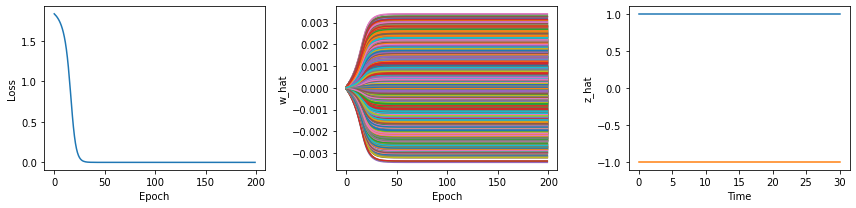

In [3]:
lr = 0.0001
nepoch = 200

w_T_hat = (0.*torch.ones((D, N), device=device)).detach()
w_T_hat.requires_grad = True

w_T_hat_flats = np.nan*np.ones((nepoch, D*N))

losses = []

for epoch in range(nepoch):

    # compute first terms (dE/dx_t) using autograd
    ## forward pass
    ### first initial condition
    x_hats_0 = [x_0s[0].clone()]
    z_hats_0 = [get_z(x_hats_0[0])]

    for ct in range(1, IT+1):
        x_hat_0 = advance(x_hats_0[ct-1], z_hats_0[ct-1], w_T_hat)
        x_hat_0.retain_grad()

        z_hat_0 = get_z(x_hat_0)

        x_hats_0.append(x_hat_0)
        z_hats_0.append(z_hat_0)

    x_hats_stack_0 = torch.stack(x_hats_0)
    z_hats_stack_0 = torch.stack(z_hats_0)

    loss_0 = loss_fn(z_hats_stack_0, targs[0])
    
    ### second initial condition
    x_hats_1 = [x_0s[1].clone()]
    z_hats_1 = [get_z(x_hats_1[0])]

    for ct in range(1, IT+1):
        x_hat_1 = advance(x_hats_1[ct-1], z_hats_1[ct-1], w_T_hat)
        x_hat_1.retain_grad()

        z_hat_1 = get_z(x_hat_1)

        x_hats_1.append(x_hat_1)
        z_hats_1.append(z_hat_1)

    x_hats_stack_1 = torch.stack(x_hats_1)
    z_hats_stack_1 = torch.stack(z_hats_1)

    loss_1 = loss_fn(z_hats_stack_1, targs[1])
    
    loss = loss_0 + loss_1
    
    ## backward pass
    loss.backward(retain_graph=True)

    ### classical factorization
    jac_x_hat_0_wrt_w_T_hats = []

    for ct in range(1, IT+1):
        jac = torch.autograd.functional.jacobian(advance, inputs=(x_hats_0[ct-1], z_hats_0[ct-1], w_T_hat))[2].reshape((D, D*N))

        jac_x_hat_0_wrt_w_T_hats.append(jac)

    summands_0 = [x_hat_0.grad@jac for x_hat_0, jac in zip(x_hats_0[1:], jac_x_hat_0_wrt_w_T_hats)]
    w_T_hat_grad_0 = torch.stack(summands_0).sum(dim=0).reshape((D, N))

    jac_x_hat_1_wrt_w_T_hats = []

    for ct in range(1, IT+1):
        jac = torch.autograd.functional.jacobian(advance, inputs=(x_hats_1[ct-1], z_hats_1[ct-1], w_T_hat))[2].reshape((D, D*N))

        jac_x_hat_1_wrt_w_T_hats.append(jac)

    summands_1 = [x_hat_1.grad@jac for x_hat_1, jac in zip(x_hats_1[1:], jac_x_hat_1_wrt_w_T_hats)]
    w_T_hat_grad_1 = torch.stack(summands_1).sum(dim=0).reshape((D, N))

    w_T_hat_grad = w_T_hat_grad_0 + w_T_hat_grad_1

    # weight update
    with torch.no_grad():
        w_T_hat -= lr*w_T_hat_grad
        if epoch == 0:
            print('x_hats_0.T', x_hats_stack_0.detach().cpu().numpy().T)
            print('x_hats_1.T', x_hats_stack_1.detach().cpu().numpy().T)
            print('w_T_hat.grad =', w_T_hat_grad.detach().cpu().numpy())
        w_T_hat.grad.zero_()

    losses.append(loss.item())
    w_T_hat_flats[epoch, :] = w_T_hat.detach().cpu().numpy().flatten()

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(w_T_hat_flats)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('w_hat')

axs[2].plot(z_hats_stack_0.detach().cpu().numpy())
axs[2].plot(z_hats_stack_1.detach().cpu().numpy())
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z_hat')